# Notebook pour essayer de match l'airfoil naca avec ma géo 

In [134]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

In [135]:
target_airfoil = []
with open('naca/naca_2412.txt','r') as foil_txt:
    for i, row in enumerate(foil_txt.readlines()):
        if len(row.split())==2: 
            x, y = row.split()
            target_airfoil.append([float(x), float(y)])    
            
target_airfoil = np.asarray(target_airfoil)


In [136]:
###  Les fonctions de ma param

def quadraticBezier(t,points):
    B_x = (1-t)*((1-t)*points[0][0]+t*points[1][0])+t*((1-t)*points[1][0]+t*points[2][0])
    B_y = (1-t)*((1-t)*points[0][1]+t*points[1][1])+t*((1-t)*points[1][1]+t*points[2][1])
    return B_x,B_y

def cambrure(x, y, numPts):
    """ Donne la cambrure avec le point qui la contrôle """ 
    curve   = []
    t       = np.array([i*1/numPts for i in range(0,numPts)])
    B_x,B_y = quadraticBezier(t,[(0.,0.),(x,y),(1.,0.)])
    curve   = list(zip(B_x,B_y))
    return curve

def find_camber_y(x, cambrure_coord):
    """ Pour un x donné il donne le y de la cambrure le plus proche """
    for k,coord_camber in enumerate(cambrure_coord):
        if coord_camber[0] > x :
            return (coord_camber[1]+cambrure_coord[k-1][1])/2                      # On prend la moyenne des deux 
    return 0.

def reconstruct_control_points(control_parameter):
    ### Les points autour desquels on bouge
    x_param_cambrure, y_param_cambrure =  control_parameter[-2:]                   # Les deux points definissant la cambrure 
    cambrure_coord = cambrure(x_param_cambrure, y_param_cambrure,16*40)
    base_points    =[[1,0.001],                                                    # Trailing edge (top)
                    [0.76,None],
                    [0.52,None],
                    [0.25,None],
                    [0.1,None],
                    [0,None],                                                      # Leading edge (top)
                    [0,None],                                                      # Leading edge (bottom)
                    [0.15,None],
                    [0.37,None],
                    [0.69,None],
                    [1,-0.001]] 

    ### Construction des control points pour génerer la courbe 
    control_points             = base_points[::]                                     
    control_points[5][1]       =  control_parameter[0] 
    control_points[5][1]       += find_camber_y(control_points[5][0], cambrure_coord)
    control_points[6][1]       = - control_parameter[0] 
    control_points[6][1]       += find_camber_y(control_points[6][0], cambrure_coord)
    for k in range(4):
        control_points[k+1][1] =  control_parameter[1+k] 
        control_points[k+1][1] += find_camber_y(control_points[k+1][0], cambrure_coord)
    for k in range(3):
        control_points[k+7][1] =  control_parameter[5+k] 
        control_points[k+7][1] +=find_camber_y(control_points[k+7][0], cambrure_coord)
    return control_points

def airfoil(ctlPts,numPts):
    """ Crée la courbe de l'airfoil avec numPts nombre de points """
    curve = []
    t     = np.array([i*1/numPts for i in range(0,numPts)])
    
    ### Calculate first Bezier curve
    midX       = (ctlPts[1][0]+ctlPts[2][0])/2
    midY       = (ctlPts[1][1]+ctlPts[2][1])/2
    B_x,B_y    = quadraticBezier(t,[ctlPts[0],ctlPts[1],[midX,midY]])
    curve      = curve+list(zip(B_x,B_y))

    ### Calculate middle Bezier Curves
    for i in range(1,len(ctlPts)-3):
        midX_1  = (ctlPts[i][0]+ctlPts[i+1][0])/2
        midY_1  = (ctlPts[i][1]+ctlPts[i+1][1])/2
        midX_2  = (ctlPts[i+1][0]+ctlPts[i+2][0])/2
        midY_2  = (ctlPts[i+1][1]+ctlPts[i+2][1])/2
        B_x,B_y = quadraticBezier(t,[[midX_1,midY_1],ctlPts[i+1],[midX_2,midY_2]])
        curve   = curve+list(zip(B_x,B_y))                     

    ### Calculate last Bezier curve
    midX    = (ctlPts[-3][0]+ctlPts[-2][0])/2
    midY    = (ctlPts[-3][1]+ctlPts[-2][1])/2
    B_x,B_y = quadraticBezier(t,[[midX,midY],ctlPts[-2],ctlPts[-1]])
    curve   = curve+list(zip(B_x,B_y))
    curve.append(ctlPts[-1])
    return curve

def bezier_curve(control_parameter, nb_point):
    """ Donne des contrôles paramètres la courbe"""
    control_point = reconstruct_control_points(control_parameter)
    return airfoil(control_point, nb_point)


Text(0.5, 1.0, 'Test print airfoil')

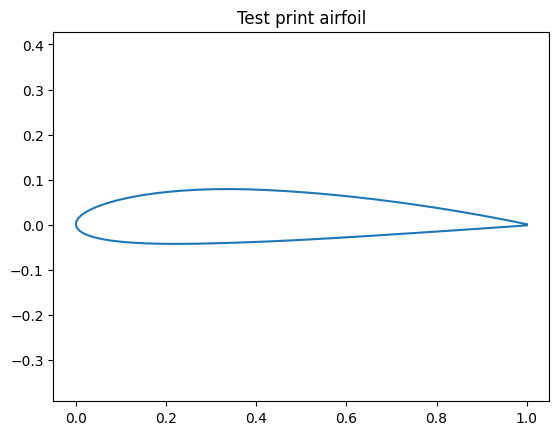

In [137]:
nb_point = len(target_airfoil)

plt.plot(target_airfoil[:,0], target_airfoil[:,1])
plt.axis("equal")
plt.title('Test print airfoil')


Text(0.5, 1.0, 'Test Bezier generation')

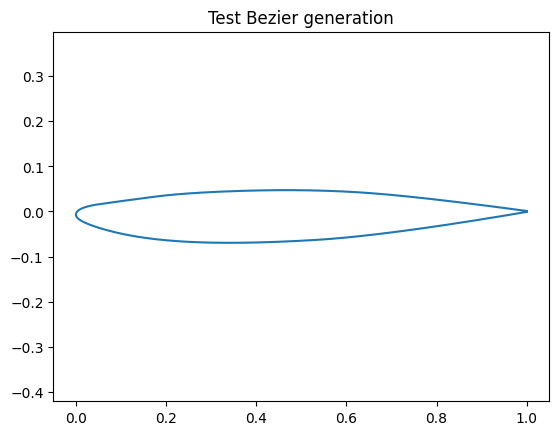

In [228]:
cond_initial = 0.53 * np.array(                                 # L'aile symétrique pour avoir une surface de 0.8
                                    [0.03, 0.08, 0.125,
                                    0.12, 0.08, -0.08, -0.1,-0.08]
                                    ) 
x = bezier_curve(a, 100)
x = np.array(x)
plt.plot(x[:,0], x[:,1])
plt.axis('equal')
plt.title("Test Bezier generation")

In [229]:
def find_y_start(L, x):
    """ Pour un x donné il donne le y de L le plus proche (1,0.99,..., 0)"""
    for k,coord_x in enumerate(L):
        if coord_x[0] < x :
            return (coord_x[1]+L[k-1][1])/2            # On prend la moyenne des deux // On peut ameliorer avec affine 
    return None

def find_y_end(L, x):
    """ Pour un x donné il donne le y de L le plus proche à la fin (0,0.1,...0.99,1)"""
    for k,coord_x in enumerate(L):
        if coord_x[0] > x :
            return (coord_x[1]+L[k-1][1])/2            # On prend la moyenne des deux // On peut ameliorer avec affine 
    print(x)
    return None


In [230]:
def cost_function(control_parameter): 
    x1 = np.linspace(0.05,0.99,50)                     # On regarde le match sur 100 points 
    x2 = np.linspace(0.05,0.99,50)
    curb = bezier_curve(control_parameter, 50)   # On crée notre courbe 
    curb = np.array(curb)
    objective = 0                                # Ce qu'on veut minimiser
    for coord_x in x1 :
        objective += abs(find_y_end(curb[len(curb)//2:,:], coord_x)-find_y_end(target_airfoil[len(target_airfoil)//2:,:], coord_x))
    for coord_x in x2 :
        objective += abs(find_y_start(curb[:len(curb)//2,:], coord_x)-find_y_start(target_airfoil[:len(target_airfoil)//2,:], coord_x))
    return objective


In [231]:
curb = np.array(bezier_curve(a, 50))


In [232]:
cost_function(a)

2.197105641599609

In [233]:
res = minimize(cost_function, cond_initial, method='Powell', tol=1e-10, options={'disp': True, 'maxiter':10000})

Optimization terminated successfully.
         Current function value: 0.062555
         Iterations: 12
         Function evaluations: 4412


Text(0.5, 1.0, 'Test Bezier generation')

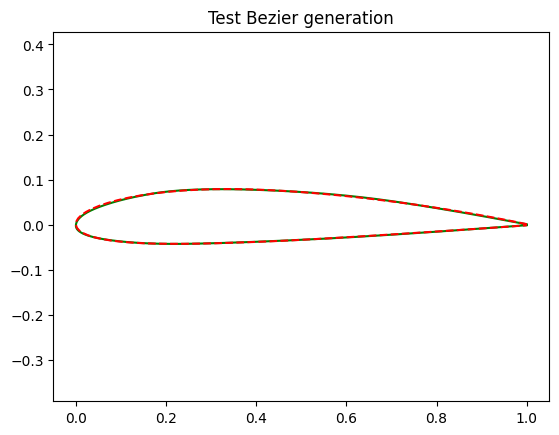

In [241]:
optimise = res.x
x = bezier_curve(optimise, 100)
x = np.array(x)
plt.plot(x[:,0], x[:,1], color= 'green')
plt.plot(target_airfoil[:,0], target_airfoil[:,1], color='red', linestyle='--')

plt.axis('equal')
plt.title("Naca")


### Ca marche trop bien !!!!!







In [ ]:
convert_naca_profile(file)